# Mapping inundation using stream gauges <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls_wo_3](https://explorer.dea.ga.gov.au/ga_ls_wo_3), [BoM Water Data Online](http://www.bom.gov.au/waterdata/)

## Background
Many of Australia's water bodies are regulated by humans. 
Flows are controlled by regulatory bodies such as the Murray Darling Basin Authority and local governments to meet the needs of water users while maintaining ecosystems dependant on the surface water. 
It is important that regulators know where the water goes when it goes overbank to help manage wetland inundations for environmental purposes and be informed of rural or residential areas likely to be flooded as a result of a large dam release.

The Bureau of Meteorology curates a network of stream gauges across Australia, making data from these available for users [online](http://www.bom.gov.au/waterdata/). While stream gauge data in itself is useful for understanding high flow river events, stream gauges do not provide any information on the extent of inundation of a river's floodplain. Combining stream gauge data with satellite imagery provides an opportunity to explore the relationship between stream gauge discharge rates and floodplain inundation. This information can be used to look at the frequency of inundation of different parts of a river's floodplain for a given river discharge range. 

## Description
This notebook steps through interacting with the Bureau of Meteorology's Water Data Online API and the [DEA Water Observations](../DEA_products/DEA_Water_Observations.ipynb) product (WOs) to explore the relationship between a given water dischare rate and the spatial footprint of floodplain inundation.

1. First we access BoM's Water Data Online to grab some data from a stream gauge
2. The stream gauge data is turned into a Flow Duration Curve and thresholded for our water discharge rates of interest
3. Satellite observations are collated that correspond to days where the thresholded water discharge rates occurred
4. The returned satellite images are cloud masked, and the frequency of inundation is calculated for each pixel for the imagery subset
5. Finally, the results are plotted

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

This notebook relies on functions from the `dea_tools.bom` module to retrieve data from the Bureau of Meteorology (BOM) [Water Data Online](http://www.bom.gov.au/waterdata/) webpage.

In [1]:
%matplotlib inline

import datacube
import numpy as np
import matplotlib.pyplot as plt
from datacube.utils import geometry, masking
from datacube.utils.geometry import CRS

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import wofs_fuser
from dea_tools.bom import get_stations, ui_select_station



### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Inundation_mapping")

## Select a stream gauge to work with

Running this cell will generate a map displaying the locations of stream gauges in Australia. It will take about 20 seconds to load. Choose a gauge on the map by clicking on it. Note that after you click on a gauge it can take a second or two to respond. 

When you have the station you want, **click the Done button before moving onto the next box**. If you don't click Done then the rest of the code won't run. If you want to choose a different gauge after having pressed the `Done` button, you must re-run this box to regenerate the map then choose another gauge and press `Done` again. 

> **Note:** If all gauges you click on return "0 observations", this could indicate an issue with fetching data from the BOM webpage. In this case, re-start the notebook and try again later

In [3]:
# Get list of available stations
stations = get_stations()

# Select a station on the map
gauge_data, station = ui_select_station(stations, zoom=11, center=(-34.72, 143.17))

**Make sure you have selected 'Done' on the top right-hand side of the map window before continuing with this workflow**

### Analysis parameters

Now that we have selected a stream gauge to plot, we need to set up some analysis parameters for the remainder of this workflow.

* `lat, lon`: The latitude and longitude of the chosen stream gauge. You *can* set this manually, but this will be automatically taken from the stream gauge you selected above.
* `buffer`: e.g. 8000. The buffer is how many meters radius around the stream gauge location you want to analyse.
* `time_range_of_analysis`: e.g. '2016-01-01', '2019-10-01'. The time range over which to extract satellite imagery.
* `cloud_free_threshold`: e.g. 0.2. A value from 0 to 1 that indicates how much cloud is acceptable per image for the satellite imagery analysis. A value of 0 means that no cloud is acceptable at all. A value of 1 indicates that a completely cloudy image can be included. This should be set around 0.2 to include scenes that are at least 80% cloud free. 

> **Note**: If you select both a large buffer AND a long time period, the amount of data you will return will be large and may crash the notebook. Try using a smaller buffer and/or a shorter time period to avoid this.

In [4]:
lat, lon = station.pos
buffer = 8000
time_range_of_analysis = "2010-01-01", "2019-10-01"
cloud_free_threshold = 0.2

## Generate a flow duration curve from the selected stream gauge
This box will generate a Flow Duration Curve (FDC) from the gauge data. A FDC is a way of displaying flow rate data that is often used by hydrologists to characterise a river. 
Flows for each day are ranked from highest to lowest flow on the y-axis. 
The x-axis is "exceedence", which means "the percentage of the time the river was at that flow or higher". It shows you the relationship between flow rates across all observations. 

The FDC plots the discharge rate on the y-axis, and the exceedence probability on the x-axis, which is equal to:

`P = 100 * [ M / (n + 1) ]`

where:

- P = the probability that a given flow will be equaled or exceeded (% of time)
- M = the ranked position on the listing (dimensionless)
- n = the number of events for period of record (dimensionless)

It is useful for looking at particular flow rates since it takes away the time element, allowing you to threshold the exceedence values to only look at events where the stream gauge reported values greater than (or less than) some threshold. It allows the user to select satellite data by flow rate rather than by date. 

The plots below show the FDC on both a linear and log scale to better understand the extremeties of the flow rates. 

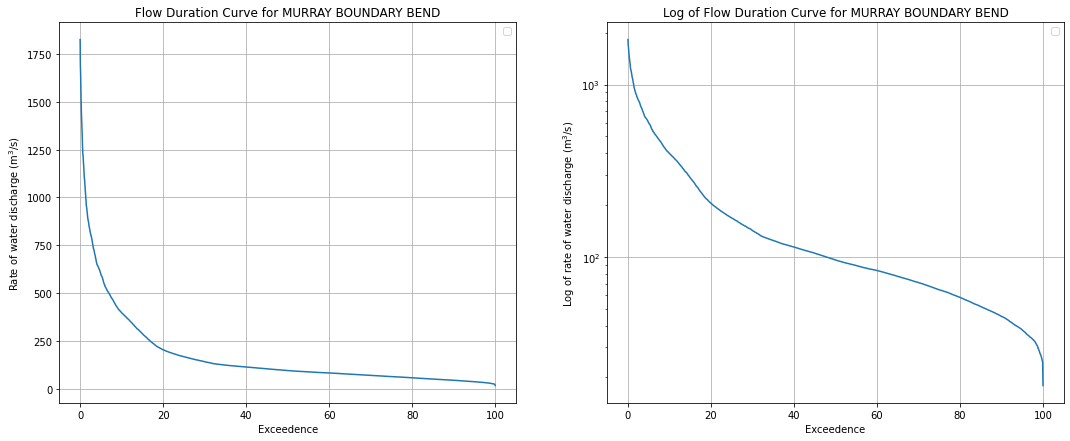

In [5]:
# Rearranging data into a flow duration curve
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values("Value")
gauge_data["rownumber"] = np.arange(len(gauge_data))

# Calculate exceedence using the formula above
gauge_data["Exceedence"] = (1 - (gauge_data.rownumber / len(gauge_data))) * 100

# Plotting the flow duration curve
fig, ax = plt.subplots(1, 2, figsize=(18, 7))
ax[0].plot(gauge_data.Exceedence, gauge_data.Value)
ax[0].set_ylabel("Rate of water discharge (m$^3$/s)")
ax[0].set_xlabel("Exceedence")
ax[0].grid(True)
ax[0].set_title(f"Flow Duration Curve for {station.name}")
ax[0].legend([])

ax[1].plot(gauge_data.Exceedence, gauge_data.Value)
ax[1].set_ylabel("Log of rate of water discharge (m$^3$/s)")
ax[1].set_xlabel("Exceedence")
ax[1].set_yscale("log")
ax[1].grid(True)
ax[1].set_title(f"Log of Flow Duration Curve for {station.name}")
ax[1].legend([]);

### Analysis parameters

We need to select part of the FDC above to explore. Generally, we are most interested in times when the river was full, so we can look at flooding events. Using the values in the plot above, select the range of water discharge rates to explore with satellite data in the next cells.

* `discharge_lower_bound`: e.g. 100. The lowest value of water discharge rate to explore with satellite data.
* `discharge_upper_bound`: e.g. 900. The lowest value of water discharge rate to explore with satellite data.

In [6]:
discharge_lower_bound = 250
discharge_upper_bound = 1850

### Check we have selected a reasonable range

If you want to change the range, do so in the cell above and rerun.

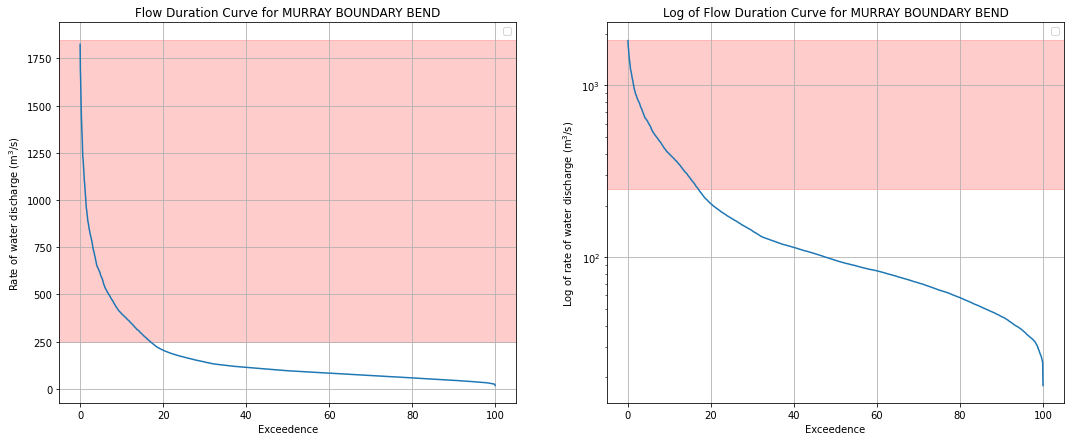

In [7]:
# Plotting the flow duration curve
fig, ax = plt.subplots(1, 2, figsize=(18, 7))
ax[0].plot(gauge_data.Exceedence, gauge_data.Value)
ax[0].set_ylabel("Rate of water discharge (m$^3$/s)")
ax[0].set_xlabel("Exceedence")
ax[0].grid(True)
ax[0].set_title(f"Flow Duration Curve for {station.name}")
ax[0].legend([])

# Add shading for the range selected above
ax[0].axhspan(discharge_lower_bound, discharge_upper_bound, color="red", alpha=0.2)

ax[1].plot(gauge_data.Exceedence, gauge_data.Value)
ax[1].set_ylabel("Log of rate of water discharge (m$^3$/s)")
ax[1].set_xlabel("Exceedence")
ax[1].set_yscale("log")
ax[1].grid(True)
ax[1].set_title(f"Log of Flow Duration Curve for {station.name}")
ax[1].legend([])

# Add shading for the range selected above
ax[1].axhspan(discharge_lower_bound, discharge_upper_bound, color="red", alpha=0.2);

## Combine gauge data with satellite data

Now that we have selected a range of water discharge rates to investigate, we want to load satellite data from the [DEA Water Observations](../DEA_products/DEA_Water_Observations.ipynb) product that corresponds to the timing of this range of values. The data are linked by date using `xarray`'s `.interp()` function. 

The code below lazy loads the data using Dask to check how many satellite passes you are about to load. 
This means it queries the available satellite imagery, then filters it based on the chosen FDC range and creates a list of dates where there was a satellite pass while the gauge was reading that value. 
It then tells you at the bottom of the cell how many scenes have been returned. 
If you want more/less passes, you will have to broaden/narrow the `discharge_lower_bound` and `discharge_upper_bound` parameters, or shorten or lengthen the `time_range_of_analysis`.

In [8]:
# Set up a query which defines the area and time period to load data for
# We need to convert the lat/lon on the stream gauge into EPSG:3577 coordinates to match up with the projection
# of the satellite data
reprojected_x, reprojected_y = (geometry.point(lon, lat, CRS("EPSG:4326")).to_crs(
    CRS("EPSG:3577")).points[0])

# Load ga_ls_wo_3 data using dask (this loads the data lazily, without
# yet bringing the actual satellite data into memory)
query = {
    "x": (reprojected_x - buffer, reprojected_x + buffer),
    "y": (reprojected_y - buffer, reprojected_y + buffer),
    "time": (time_range_of_analysis),
    "crs": "EPSG:3577"
}

wo = dc.load(product="ga_ls_wo_3",
             resolution=(-30, 30),
             output_crs='EPSG:3577',
             group_by="solar_day",
             fuse_func=wofs_fuser,
             dask_chunks={},
             **query)

# Merging satellite data with gauge data by timestamp
gauge_data_xr = gauge_data.to_xarray()
merged_data = gauge_data_xr.interp(Timestamp=wo.time, method="nearest")

# Here is where it takes into account user input for the FDC
specified_level = merged_data.where(
    (merged_data.Value > discharge_lower_bound) &
    (merged_data.Value < discharge_upper_bound),
    drop=True,
)

# Get list of dates to keep
date_list = specified_level.time.values

print(f"You are about to load {specified_level.time.shape[0]} satellite passes")

You are about to load 115 satellite passes


### Drop cloudy observations and load WOs into memory

The available images flagged in the cell above to not account for cloudy observations, which we need to mask for. 
The cells below will load the selected WOs images with `.compute()` and then cloud filter the images and discard any that to not meet the `cloud_free_threshold` criteria. 
It does this by using the `.make_mask()` function to calculate the fraction of cloud pixels in each image.
The output will tell you how many passes remain after they were cloud filtered.

In [9]:
# Load the passes that happened during the specified flow parameters
specified_passes = wo.sel(time=date_list).compute()

# Calculate the number of cloudy pixels per timestep
cc = masking.make_mask(specified_passes.water, cloud=True)
ncloud_pixels = cc.sum(dim=["x", "y"])

# Calculate the total number of pixels per timestep
npixels_per_slice = specified_passes.water.shape[1] * specified_passes.water.shape[2]

# Calculate the proportion of cloudy pixels
cloud_pixels_fraction = ncloud_pixels / npixels_per_slice

# Filter out "too cloudy" passes (i.e. more than 50% cloud)
clear_specified_passes = specified_passes.water.isel(
    time=cloud_pixels_fraction < cloud_free_threshold)

print(
    f"After cloud filtering, there are "
    f"{clear_specified_passes.time.shape[0]} passes available")

After cloud filtering, there are 93 passes available


## Calculate how frequently each pixel was observed as wet

Now that the satellite imagery has been cloud masked, we want to know how frequently each pixel from our water discharge rate and cloud masked imagery stack was wet and dry.

In [10]:
# Identify all wet and dry pixels
wet = masking.make_mask(clear_specified_passes, wet=True).sum(dim="time")
dry = masking.make_mask(clear_specified_passes, dry=True).sum(dim="time")

# Calculate how frequently each pixel was wet when it was observed
clear = wet + dry
frequency = wet / clear

# Remove persistent NAs that occur due to mountain shadows
frequency = frequency.fillna(0)

# Set pixels that remain dry 100% of the time to nodata so they appear white
frequency = frequency.where(frequency != 0)

### Plot inundation frequency for our area of interest

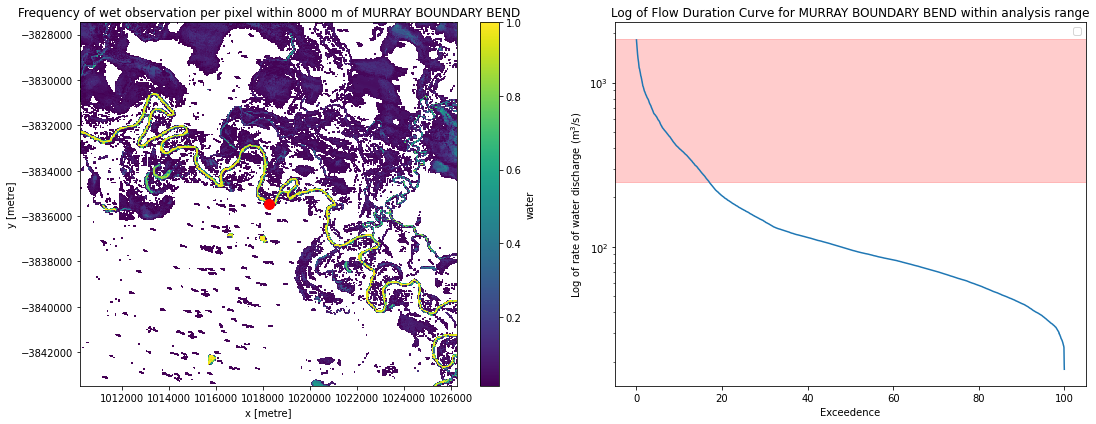

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

ax1 = frequency.plot(ax=ax[0])
ax[0].set_title(f'Frequency of wet observation per pixel within {buffer} m of {station.name}')
ax[0].plot(reprojected_x, reprojected_y, 'ro', markersize=10)
ax[0].ticklabel_format(useOffset=False, style='plain')

ax2 = gauge_data.plot(x='Exceedence', y='Value', ax=ax[1]) 
ax2 = plt.axhspan(discharge_lower_bound, discharge_upper_bound, color='red', alpha=0.2)
ax[1].set_title(f'Log of Flow Duration Curve for {station.name} within analysis range')
ax[1].set_ylabel('Log of rate of water discharge (m$^3$/s)')
ax[1].set_xlabel('Exceedence')
ax[1].set_yscale('log')
ax[1].legend([])

plt.tight_layout()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2023

**Compatible datacube version:** 

In [12]:
print(datacube.__version__)

1.8.5


## Tags
<!-- Browse all available tags on the DEA User Guide's [Tags Index](https://knowledge.dea.ga.gov.au/genindex/) -->